# Test NN for Entropy Closure #

Test Data is generated from RTSN code

Load all needed modules

In [1]:
# Imports
import pandas as pd
import random                        # for generating random numbers
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt      # MATLAB like plotting routines
from sklearn.preprocessing import normalize

Load and preprocess Training Data

In [2]:
def preprocess_data(filename):
    # reading csv file
    dataFrameInput = pd.read_csv(filename) #outputs a dataframe object

    idx = 0
    xDataList = list()
    yDataList = list()
    data = dataFrameInput.values  # numpy array

    ## Somehow t = 0 has an odd number of elements, just cut it out

    for row in data:
        if (row[2] > 0):
            if (idx % 2 == 0):
                xDataList.append(row)
            else:
                yDataList.append(row)

            idx = idx + 1

    # merge the lists
    DataList = list()
    for rowX, rowY in zip(xDataList, yDataList):
        DataList.append([rowX, rowY])

    # Shuffle data

    random.shuffle(DataList)

    DataArray = np.asarray(DataList)
    #print(DataArray.shape)

    # Strip off header information, i.e. the first 3 cols
    DataArraySlim = DataArray[:, :, 3:]
    #print(DataArraySlim.shape)

    # split in train and test data (ratio 4:1)
    DataTrain = DataArraySlim[:4 * int(DataArraySlim.shape[0] / 5)]
    DataTest = DataArraySlim[4 * int(DataArraySlim.shape[0] / 5):]

    # Split in x (input) and y (output) data
    xDataTrain = DataTrain[:, 0, :]
    yDataTrain = DataTrain[:, 1, :]
    xDataTest = DataTest[:, 0, :]
    yDataTest = DataTest[:, 1, :]

    #Normalize Input
    xDataTrain = normalize(xDataTrain, axis=1, norm='l1')
    xDataTest = normalize(xDataTest, axis=1, norm='l1')

    return (xDataTrain,yDataTrain,xDataTest,yDataTest)

Review Training Data

In [3]:
# Load the Data
(xDataTrain,yDataTrain,xDataTest,yDataTest) = preprocess_data("trainNN.csv")


## Start the Neural Network ##
First, load the needed python modules


##Build the Network - Take one: Simple FCN (Fully connected Network) ###

* Input: Solution of the Kinetic solver at time-step n and a cell, called u 
* Output: Legendre multiplier of the entropy closure, called alpha

u and alpha have the same length, which is given by the size of the moment basis.



In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
# Build the network:
def create_model():
  model = tf.keras.models.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(4,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(512, activation='relu', input_shape=(64,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu', input_shape=(256,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu', input_shape=(128,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4,)
  ])

  model.summary()
  #plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
  '''
  bfgs_opt = tfp.optimizer.bfgs_minimize(
    value_and_gradients_function, initial_position, tolerance=1e-08, x_tolerance=0,
    f_relative_tolerance=0, initial_inverse_hessian_estimate=None,
    max_iterations=50, parallel_iterations=1, stopping_condition=None,
    validate_args=True, max_line_search_iterations=50, name=None
    )
  '''
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', metrics=['accuracy'])

  return model


### Compile the model ###

In [5]:
model = create_model()

# Let's use the Adam optimizer for learning
#model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1280      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

## Train the model ##


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               1280      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

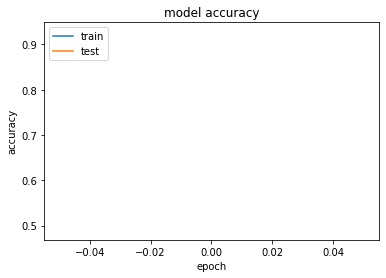

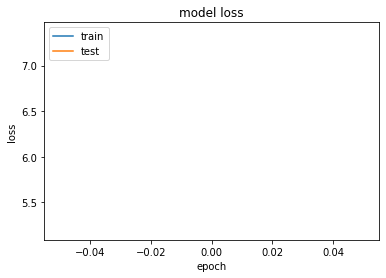

In [6]:
#from tensorflow.keras.callbacks import ReduceLROnPlateau

#rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)


# Create the model
model = create_model()

history = model.fit(xDataTrain, yDataTrain,validation_split=0.33, epochs=1, batch_size=10, verbose=1)

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate the Model accuracy


In [7]:
score = model.evaluate(xDataTest, yDataTest)
print('Test score:', score[0])
print('Test accuracy:', score[1])

5857/5857 [==============================] - 5s 841us/step - loss: 5.2513 - accuracy: 0.9269
Test score: 5.251279830932617
Test accuracy: 0.9269158244132996


##Make a prediction

In [8]:
print(np.asarray([xDataTest[0]]).shape)
pred = model.predict(np.asarray([xDataTest[0]]))
print(pred)

(1, 4)
[[-10.372878     8.148684     0.02365703   9.866678  ]]


## Save trained model

In [9]:
print(tf.version.VERSION)

!mkdir -p saved_model
model.save('saved_model/my_model')


2.3.0
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [10]:
# Prepare model for download

!zip -r model.zip saved_model

  adding: saved_model/ (stored 0%)
  adding: saved_model/my_model/ (stored 0%)
  adding: saved_model/my_model/variables/ (stored 0%)
  adding: saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: saved_model/my_model/variables/variables.index (deflated 67%)
  adding: saved_model/my_model/saved_model.pb (deflated 90%)
  adding: saved_model/my_model/assets/ (stored 0%)


In [12]:
# download model
#from google.colab import files
#files.download("model.zip")

## Take two: A more sophisticated Loss Function ##

The Loss is defined as the Objective function of the minimal entropy problem:

$L(u,\alpha, \theta) = <\eta_*(\alpha(\theta) \cdot m(v))>_v - \alpha(\theta) \cdot u$





#### Easiest case 
$\alpha, u\in\mathbb{R}$

Entropy $\eta(\alpha\cdot m) = exp(\alpha\cdot m)$ 

Spherical harmonics basis for $M_0$: $ m_0 = \sqrt{\left(\frac{1}{4\pi}\right)}$

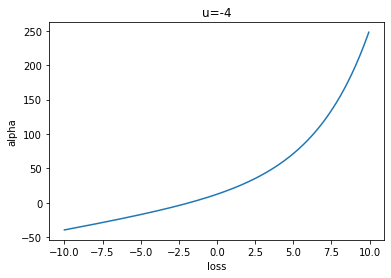

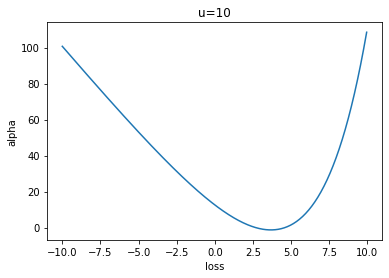

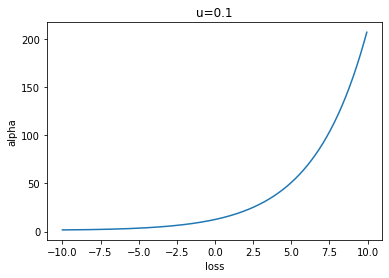

In [15]:

def loss1D(u, alpha):
    return 4*np.pi*np.exp(alpha*np.sqrt(1/(4*np.pi))) - alpha*u

# not realizable moment
u = -4
alpha = np.arange(-10.0, 10.0, 0.05)
plt.figure()
plt.plot(alpha,loss1D(u,alpha))
plt.ylabel('alpha')
plt.xlabel('loss')
plt.title('u=-4')
plt.show()

#realizable moment
u = 10
alpha = np.arange(-10.0, 10.0, 0.05)
plt.figure()
plt.plot(alpha,loss1D(u,alpha))
plt.ylabel('alpha')
plt.xlabel('loss')
plt.title('u=10')
plt.show()

# moment close to the boundary of the realizable set
u = 0.1
alpha = np.arange(-10.0, 10.0, 0.05)
plt.figure()
plt.plot(alpha,loss1D(u,alpha))
plt.ylabel('alpha')
plt.xlabel('loss')
plt.title('u=0.1')
plt.show()

In [57]:
# build the network
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

# Custom Loss
def custom_loss1d(u_input, alpha_pred): # (label,prediciton)
    return 4*math.pi*tf.math.exp(alpha_pred*np.sqrt(1/(4*np.pi))) - alpha_pred*u_input
  


# Build the network:
def create_model():
    
    # Define the input
    input_ = keras.Input(shape=(1,))
    
    # Hidden layers
    hidden1 = layers.Dense(4, activation="tanh")(input_)  
    hidden2 = layers.Dense(8, activation="tanh")(hidden1)  
    hidden3 = layers.Dense(32, activation="tanh")(hidden2)  
    hidden4 = layers.Dense(8, activation="tanh")(hidden3)  
    hidden5 = layers.Dense(4, activation="tanh")(hidden4)  
    
    #Define the ouput
    output_ = layers.Dense(1)(hidden5)

    # Create the model
    model = keras.Model(inputs=[input_], outputs=[output_] )
    
    
    model.summary()
    
    # tf.keras.losses.MeanSquaredError()
    model.compile(loss= custom_loss1d, optimizer="adam",
              metrics=["accuracy"])

    return model


In [58]:

# build training data and shuffe!
uTrain = np.arange(0.1, 100, 0.1)
random.shuffle(uTrain)


In [59]:
model = create_model()


Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_74 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_75 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_76 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_77 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_78 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_79 (Dense)             (None, 1)               

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


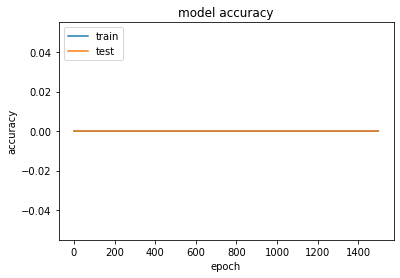

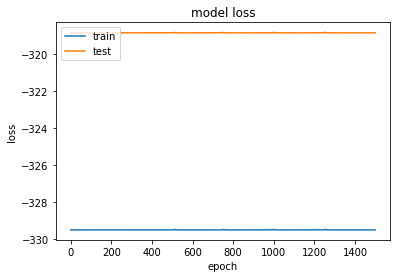

In [62]:

# use uTrain as labels, since the custom loss is prepared that way
history = model.fit(uTrain, uTrain,validation_split=0.33, epochs=1500, batch_size=1000, verbose=1)

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### The more complicated case ###

In [ ]:
## Define the custom loss function
def minimal_Entropy_Loss(u,alpha):

  # Compute the spherical harmonics ( up to degree 2, hardcoded for testing puproses)
  def spherical_harmonics(my, phi):
    m = np.zeros(9)
    m[0] = np.sqrt(1/(4*np.pi))
    
    m[1] = -1* np.sqrt(3/(4*np.pi))*np.sqrt(1-my*my)*np.sin(phi)
    m[2] = np.sqrt(3/(4*np.pi))*my
    m[3] = -1*np.sqrt(3/(4*np.pi))*np.sqrt(1-my*my)*np.cos(phi)

   # m[4] = np.sqrt(15/(16*np.pi)) * (1-my*my) * np.sin(2 * phi)
   # m[5] = -1 * np.sqrt(15/(4*np.pi)) * my * np.sqrt(1-my*my) * sin(phi)
   # m[6] = np.sqrt(5/(16*np.pi))*(3*my*my-1)
   # m[7] = -1 * sqrt(15/(4 * np.pi)) * np.sqrt(1-my * my) * np.cos(phi)
   # m[8] = np.sqrt(15/(16* np.pi))*(1-my * my) * np.cos(2*phi)

  return m

  # Set integration points
  def setPointsWeights(order):
    # legendre points and weights to interpolate my
    (my,w) = np.polynomial.legendre.leggauss(order)

    # points and weights to interpolate phi
    phi = np.zeros(order)
   
    for i in range(0,order):
        phi[i] = (i+0.5)*np.pi/ order

    #tensorized points and weights
    nq =  2 * pow(order, 2 )

    pointsOut = np.zeros([2,nq])
    weightsOut = np.zeros(nq)
    for j in range(0,order):
      for i in range(0,order):
        pointsOut[j * ( 2 * order ) + i,0] = my[j]
        pointsOut[j * ( 2 * order ) + i,1] = phi[i]
        weightsOut[j * ( 2 * order ) + i] = np.pi / order * w[j]

    return (pointsOut,weightsOut)
   
  def entropy_MB(alpha,m):
     return exp(alpa*m)
  # define the entropy part
  def entropy_part(alpha):

    result  = 0.0

    (points ,weights) = setPointsWeights(12) # order 12

    for i in range(0,weights.size):
      m = spherical_harmonics(points[i,0], points[i,1])

      result+=entropyDual(alpha, m)*weights[i]


    return result

  # Stack together the loss function
  loss = entropy_part(alpha) - alpha*u;
  return loss
